In [1]:
from ultralytics import YOLO
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load your YOLO segmentation model
model = YOLO("/home/martyn/Thesis/YOLOv8/axle_seg.pt")

In [44]:
# Path to your input image
image_path = "/home/martyn/Thesis/pose-estimation/data/scenes/scenes_axle/scenes_single/scene_05/rgb.png"

# Perform inference
start_time = time.time()
results = model.predict(image_path, imgsz=[480,640], device='cuda:0')
inference_time = time.time() - start_time

print ("Inference Time GPU (s):", inference_time)


image 1/1 /home/martyn/Thesis/pose-estimation/data/scenes/scenes_axle/scenes_single/scene_05/rgb.png: 480x640 1 Axle, 7.6ms
Speed: 12.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Inference Time GPU (s): 0.03590226173400879


In [45]:
result = results[0]
annotated_image = result.plot()

# Save the annotated image with the same size as the original
def save_annotated_image(image, save_path="output.png"):
    dpi = 100  # Dots per inch
    height, width, _ = image.shape

    # Create a figure that matches the image dimensions
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # Fill the entire canvas
    ax.imshow(image)
    ax.axis('off')

    # Save the image
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# Call the function to save
segmentation_path = "/home/martyn/Thesis/pose-estimation/data/scenes/scenes_axle/scenes_single/scene_05/segmentation_result.png"
save_annotated_image(annotated_image, save_path=segmentation_path)

In [46]:
# Bounding Box
boxes = result.boxes
print("Bounding Box:\n", boxes.xywh)

#Confidence Score
conf = boxes.conf
print("Confidence Score\n", conf)

Bounding Box:
 tensor([[288.2124, 278.7726, 564.2031, 398.4976]], device='cuda:0')
Confidence Score
 tensor([0.9121], device='cuda:0')


In [47]:
# Masks
mask_data = result.masks.data
mask_size = result.masks.orig_shape
print('Mask Data:\n', mask_data)
print("Mask Size.", mask_size)

Mask Data:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Mask Size. (480, 640)


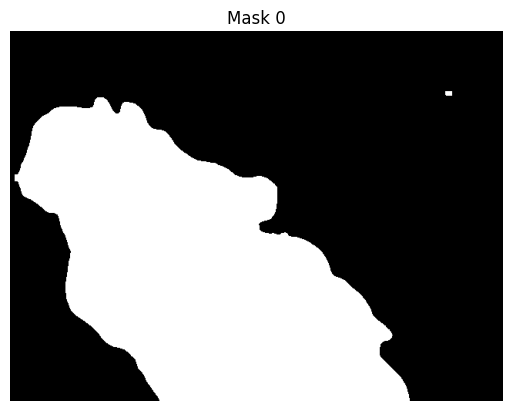

In [48]:
# Plot each mask
for i, mask in enumerate(result.masks.data):
    # Convert the mask to binary format
    binary_mask = mask.cpu().numpy().astype(np.uint8)

    # Plot the binary mask
    plt.figure()
    plt.title(f"Mask {i}")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")
    plt.show()

In [49]:
# Initialize an empty combined mask with the same shape as the masks
height, width = result.masks.data[0].shape[-2:]
combined_mask = np.zeros((height, width), dtype=np.uint8)

# Combine all masks for the same object (e.g., masks with the same category_id)
for mask in result.masks.data:
    binary_mask = mask.cpu().numpy().astype(np.uint8)
    combined_mask = np.logical_or(combined_mask, binary_mask).astype(np.uint8)

# Save the combined mask
def save_combined_mask(mask, save_path="combined_mask.png"):
    dpi = 100  # Dots per inch
    height, width = mask.shape

    # Create a figure that matches the mask dimensions
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # Fill the entire canvas
    ax.imshow(mask, cmap="gray")
    ax.axis("off")

    # Save the figure
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# Call the function to save the mask
mask_path = "/home/martyn/Thesis/pose-estimation/data/scenes/scenes_axle/scenes_single/scene_05/mask_yolo.png"
save_combined_mask(combined_mask, save_path=mask_path)

In [50]:
# Convert to json
import pycocotools.mask as cocomask
import json

# Prepare the output data
output_data = []
scene_id = 0
image_id = 0

for result in results:
    for i, box in enumerate(result.boxes):
        # Get segmentation mask
        mask = result.masks.data[i].cpu().numpy().astype(np.uint8)  # Get binary mask

        # Encode mask as COCO RLE
        rle = cocomask.encode(np.asfortranarray(mask))
        rle["counts"] = rle["counts"].decode("ascii")

        # Get bounding box [x, y, width, height]
        bbox = box.xywh.cpu().numpy().tolist()

        # Append data
        output_data.append({
            "scene_id": scene_id,
            "image_id": image_id,
            "category_id": int(box.cls),  # Class ID
            "bbox": bbox,
            "score": float(box.conf),  # Confidence score
            "segmentation": {
                "size": [mask.shape[0], mask.shape[1]],  # [height, width]
                "counts": rle["counts"]
            }
        })

# Save the output to a JSON file in one line
output_file = "yolo_segmentation_coco_one_line.json"
with open(output_file, "w") as f:
    #json.dump(output_data, f, separators=(",", ":"))  # Compact JSON with no spaces
    json.dump(output_data, f, indent=4)

print(f"Results saved to {output_file}")

Results saved to yolo_segmentation_coco_one_line.json
